# Intro to SpatialData

This notebook introduces the core concepts and basic operations in `SpatialData` using a small subset of a [spatial transcriptomics murine liver dataset (Guilliams et al. 2022)](https://doi.org/10.1016/j.cell.2021.12.018). We will also introduce essential plotting with the [`spatialdata-plot`](https://spatialdata.scverse.org/en/stable/) companion library.

> **Note**
>
> The purpose of the `SpatialData` framework is to lay the foundation for methods/pipelines to analyze spatial omics data. It is not intended to analyze data itself, but to provide a common data model and APIs to manipulate spatial omics data. Browse the other tutorials for a demo of how various analysis packages work with `SpatialData`: [see the "External tutorials" section](../../notebooks.md).

## Key terms and data model

`SpatialData` objects are representations of spatial omics data, which are manipulated with the *`SpatialData`* framework. On-disk, these are stored as `.zarr` stores, which are essentially folders containing data and metadata in a structured, but flexible format.

We can think of a `SpatialData` object as a container for various `Elements`. An `Element` is either a `SpatialElement` (`Images`, `Labels`, `Points`, `Shapes`) or a `Table`. Here is a brief description:
- `Images`: H&E, staining images
- `Labels`: pixel-level segmentation
- `Points`: transcripts locations with gene information, landmarks points
- `Shapes`: cell/nucleus boundaries, subcellular structures, anatomical annotations, regions of interest (ROIs)
- `Tables`: sparse/dense matrices annotating the the `SpatialElements` or storing arbitrary (non-spatial) metadata. They do not contain spatial coordinates.

We can categorize the `SpatialElements` into two broad types:
- `Rasters`: Data made up of pixels: including `Images` and `Labels`
- `Vectors`: Data made up of points and lines. Polygons are also vectors, since they are a simply a list of connected points. `Points` and `Shapes` are elements of this type.

We will see examples of manipulating these below and leave advanced usage in other tutorials.

> **See Also**
> 
> 1. [Glossary](../../../../glossary.md) for other key terms
> 2. [Advanced Data Structures part 1](models1.ipynb) and [Advanced Data Structures part 2](models2.ipynb)
> 3. [Tables](tables.ipynb)

<img src="attachments/elements.png" alt="SpatialData Elements" style="max-width: 800px;">

In [2]:
import spatialdata as sd
import spatialdata_plot  # noqa: F401

/Users/chrism/git/spatialdata-notebooks/.venv/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


## Load SpatialData `.zarr` data from disk

Download the example dataset from [here](https://s3.embl.de/spatialdata/spatialdata-sandbox/mouse_liver.zip) and unzip it. You should see a folder with the `.zarr` extension, which we will set as the `data_path` to load from disk. You can also use symlinks to make the data_path point to data stored outside the current working directory.

`SpatialData` objects are stored in the SpatialData Zarr format (find more in our [design doc](https://github.com/scverse/spatialdata/blob/main/docs/design_doc.md) and [developer resources](https://github.com/scverse/spatialdata-notebooks/tree/4e430ab0c0c316b101c40c5918d3c903a71d51db/notebooks/developers_resources/storage_format)), which uses [Zarr](https://zarr.dev/) for on-disk storage. Again, Zarr stores are simply folders containing data and metadata in a standardized, flexible format. 

The spatialdata framework has three ways to construct SpatialData objects:
- You can read a `SpatialData` object that has already been saved to `.zarr` in the SpatialData Zarr format …
    - … from disk.
    - … from the cloud ([find more here](https://github.com/scverse/spatialdata/discussions/526)).
- You can use the reader functions from [`spatialdata-io`](https://spatialdata.scverse.org/projects/io/en/latest/) for [supported spatial omics platforms](https://github.com/scverse/spatialdata-io) (e.g. Visium HD, MERSCOPE, etc.).
- You can construct a `SpatialData` object from scratch using our Python `spatialdata` APIs …
    - … using the `SpatialData` class initializer.
    - … by adding elements incrementally.

> **See Also**
>
> Here below we will simply read a `SpatialData` object from disk. See the [advanced data structures](models1.ipynb) tutorial for technical details and considerations.

In [3]:
data_path = "../../datasets/mouse_liver.zarr"
sdata = sd.read_zarr(data_path)
sdata

/Users/chrism/git/spatialdata-notebooks/.venv/lib/python3.12/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


SpatialData object, with associated Zarr store: /Users/chrism/git/spatialdata-notebooks/datasets/mouse_liver.zarr
├── Images
│     └── 'raw_image': DataTree[cyx] (1, 6432, 6432), (1, 1608, 1608)
├── Labels
│     └── 'segmentation_mask': DataArray[yx] (6432, 6432)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 3) (2D points)
├── Shapes
│     └── 'nucleus_boundaries': GeoDataFrame shape: (3375, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (3375, 99)
with coordinate systems:
    ▸ 'global', with elements:
        raw_image (Images), segmentation_mask (Labels), transcripts (Points), nucleus_boundaries (Shapes)

## Explore the `Elements` of the `SpatialData` object

Let's explore each element type and how they are represented:
- Images: [`xarray.DataArray`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html) or [`xarray.DataTree`](https://docs.xarray.dev/en/stable/generated/xarray.DataTree.html) objects respectively for single-scale or multi-scale images
- Labels: [`xarray.DataArray`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html) or [`xarray.DataTree`](https://docs.xarray.dev/en/stable/generated/xarray.DataTree.html) objects containing integer codes for different labels
- Points: [`dask.DataFrame`](https://docs.dask.org/en/stable/dataframe.html) objects containing point coordinates, (lazy version of [`pandas.DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) objects)
- Shapes: [`geopandas.GeoDataFrame`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.html) objects containing geometric objects like polygons
- Tables: [`anndata.AnnData`](https://anndata.readthedocs.io/en/stable/generated/anndata.AnnData.html) objects for tabular data with annotations

> **See Also**
> 
> For advanced manipulation of `Elements` and how to handle annotations with `Tables`, see the ["SpatialElements and tables"](models2.ipynb) tutorial and the ["Tables"](tables.ipynb) tutorial.


### Images

Images are represented as `xarray.DataArray` or `xarray.DataTree` objects respectively for single-scale or multi-scale images. They will either be 2D (cyx) or 3D (czyx) arrays where the `c` axis is for channels and the `z`, `y`, and `x` axes are spatial coordinates. 

We can access elements using keys e.g. `sdata[key]`, similar to dictionaries.

In [4]:
sdata["raw_image"]

<xarray.DataTree>
Group: /
├── Group: /scale0
│       Dimensions:  (c: 1, y: 6432, x: 6432)
│       Coordinates:
│         * c        (c) int64 8B 0
│         * y        (y) float64 51kB 0.5 1.5 2.5 3.5 ... 6.43e+03 6.43e+03 6.432e+03
│         * x        (x) float64 51kB 0.5 1.5 2.5 3.5 ... 6.43e+03 6.43e+03 6.432e+03
│       Data variables:
│           image    (c, y, x) uint16 83MB dask.array<chunksize=(1, 256, 256), meta=np.ndarray>
└── Group: /scale1
        Dimensions:  (c: 1, y: 1608, x: 1608)
        Coordinates:
          * c        (c) int64 8B 0
          * y        (y) float64 13kB 2.0 6.0 10.0 14.0 ... 6.422e+03 6.426e+03 6.43e+03
          * x        (x) float64 13kB 2.0 6.0 10.0 14.0 ... 6.422e+03 6.426e+03 6.43e+03
        Data variables:
            image    (c, y, x) uint16 5MB dask.array<chunksize=(1, 256, 256), meta=np.ndarray>

Images can have multiple scales, which are stored in a pyramid for downsampled representations useful for more efficient visualization and analysis. We can access a single scale using the `get_pyramid_levels` function, where `0` is the highest resolution, `1` is downsampled by a factor of (usually 2), `2` is downsampled by another factor (usually 2, with respect to the previous scale), etc.

In this case, our image has 2 scales. Let's access the highest resolution image.

In [5]:
sd.get_pyramid_levels(sdata["raw_image"], n=0)

<xarray.DataArray 'image' (c: 1, y: 6432, x: 6432)> Size: 83MB
dask.array<from-zarr, shape=(1, 6432, 6432), dtype=uint16, chunksize=(1, 256, 256), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) int64 8B 0
  * y        (y) float64 51kB 0.5 1.5 2.5 3.5 ... 6.43e+03 6.43e+03 6.432e+03
  * x        (x) float64 51kB 0.5 1.5 2.5 3.5 ... 6.43e+03 6.43e+03 6.432e+03
Attributes:
    transform:  {'global': Identity }

To view image properties such as axes and channel names, `SpatialData` provides some helper functions. More helper functions can be found in the [API](../../../../api.md) page.

In [6]:
sd.models.get_axes_names(sdata["raw_image"])

('c', 'y', 'x')

Here we see that our image only has one channel for DAPI staining.


In [7]:
sd.models.get_channel_names(sdata["raw_image"])

[np.int64(0)]

Let's use `spatialdata-plot` to show the image (DAPI staining for nuclei).

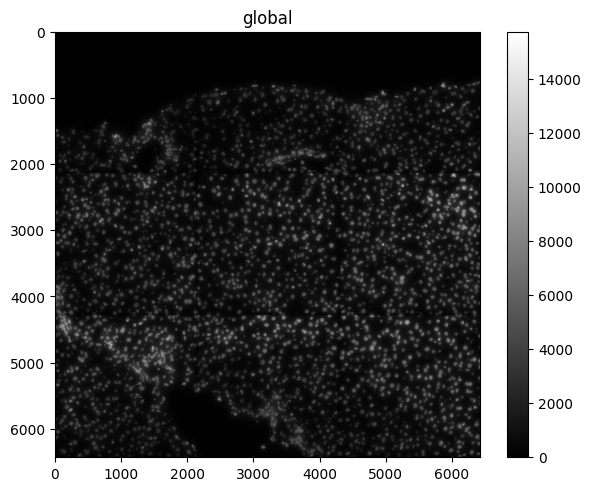

In [8]:
sdata.pl.render_images("raw_image", cmap="gray").pl.show()

### Points

Points are represented as `dask.DataFrame` objects containing point coordinates, (lazy version of `pandas.DataFrame` objects). By lazy-loading the dataframe, we can reduce memory usage and only loading in-memory for computations.

For spatial transcriptomics datasets measuring single-molecules, coordinates are stored in columns `x` and `y` (optionally `z` for 3D) and have an additional column annotating gene identity.

> **See Also**
>
> `Points` instances can be in 2D or 3D though some operations, such as `rasterize()`, or visualization operations currently do not support the 3D component.

In [9]:
sdata["transcripts"]

,x,y,gene
npartitions=1,,,
,float64,float64,category[unknown]
,...,...,...


We can easily convert the `dask.DataFrame` to a `pandas.DataFrame` so it is easier to work with. Note that this will load the entire object into memory. If the data is large you can used directly the `dask` APIs for the manipulation of the dataframe.

In [10]:
sdata["transcripts"].compute()

,x,y,gene
0,433.0,1217.0,Adgre1
1,151.0,1841.0,Adgre1
2,139.0,1983.0,Adgre1
3,1349.0,1601.0,Adgre1
4,784.0,1732.0,Adgre1
...,...,...,...
1998863,5743.0,5233.0,Lyve1
1998864,5721.0,4581.0,Lyve1
1998865,5807.0,4842.0,Lyve1
1998866,5843.0,5309.0,Lyve1


Let's visualize the points. Note that plotting automatically switches from `matplotlib` to `datashader` when the number of points is large, ensuring performant rendering. As you can see below, it will be more useful to plot subsets of transcripts, such as specific genes.

/home/chrism/git/spatialdata-notebooks/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/chrism/git/spatialdata-notebooks/.venv/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/chrism/git/spatialdata-notebooks/.venv/lib/python3.11/site-packages/spatialdata/_core/_elements.py:115: UserWarning: Key `transcripts` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                


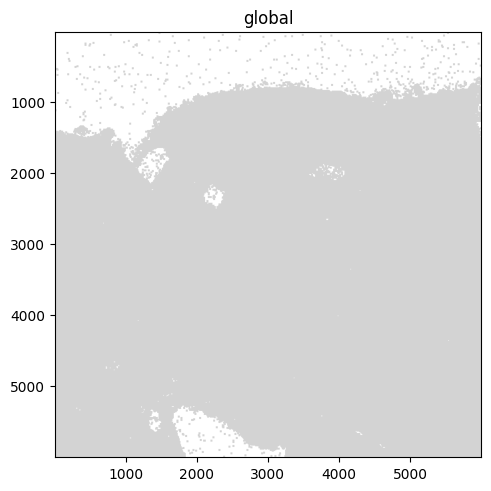

In [11]:
sdata.pl.render_points("transcripts").pl.show()

Let's plot the transcripts colored by gene. We can also use the `groups` argument to plot transcripts for a subset of genes.

> **Note**
>
> If the color column has many unique values (e.g. 1000s of genes), plotting will slow down dramatically.

/home/chrism/git/spatialdata-notebooks/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/chrism/git/spatialdata-notebooks/.venv/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/chrism/git/spatialdata-notebooks/.venv/lib/python3.11/site-packages/spatialdata/_core/_elements.py:115: UserWarning: Key `transcripts` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/home/chrism/git/spatialdata-notebooks/.venv/lib/python3.11/site-packages/spatialdata_plot/pl/utils.py:775: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avo

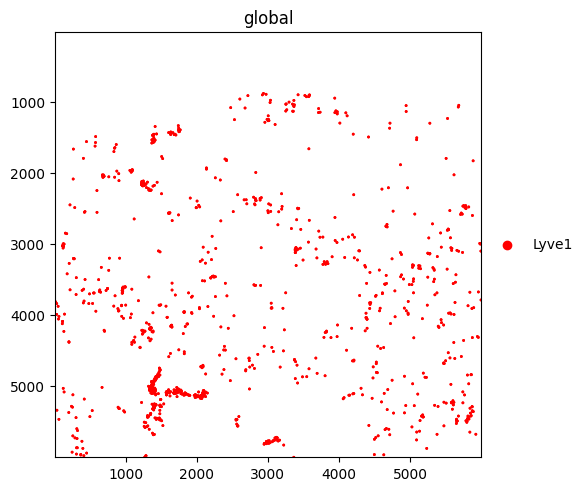

In [15]:
sdata.pl.render_points("transcripts", color="gene", groups="Lyve1", palette="red").pl.show()


### Shapes

Shapes are represented as `geopandas.GeoDataFrame` objects containing geometric objects like polygons. For a comprehensive guide on working with `geopandas.GeoDataFrame` objects, please refer to the [`geopandas` documentation](https://geopandas.org/en/stable/docs.html).

In [18]:
sdata["nucleus_boundaries"]

,geometry
cell_ID,
99,"POLYGON ((6277 798, 6277 799, 6272 799, 6272 8..."
142,"POLYGON ((6427 6123, 6423 6123, 6423 6124, 641..."
208,"POLYGON ((3747 858, 3747 859, 3746 859, 3746 8..."
235,"POLYGON ((752 6144, 752 6145, 763 6145, 763 61..."
336,"POLYGON ((5174 935, 5174 936, 5172 936, 5172 9..."
...,...
7652,"POLYGON ((1094 6028, 1094 6029, 1091 6029, 109..."
7680,"POLYGON ((1324 6063, 1324 6064, 1320 6064, 132..."
7694,"POLYGON ((1692 6063, 1692 6064, 1686 6064, 168..."


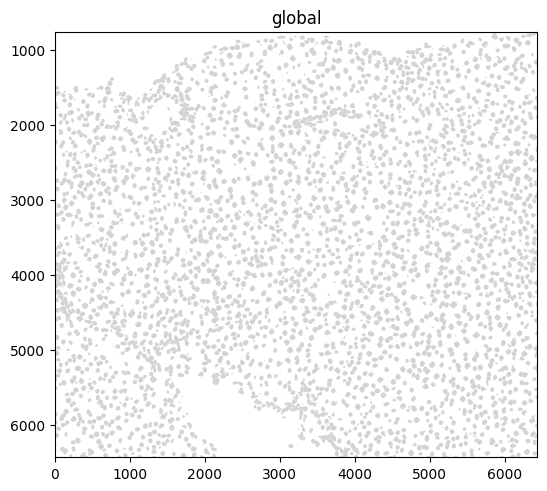

In [19]:
sdata.pl.render_shapes("nucleus_boundaries").pl.show()

### Tables

Annotated matrices are represented as `anndata.AnnData` objects. Ingested datasets will usually have a table located at `sdata['table']` for a count/abundance matrix. This enables downstream analysis with tools like Scanpy, scVI, etc.

For different spatial technologies this quantifies:
- transcriptomics: transcript counts;
- spatial proteomics: marker abundances;
- slide-based assays: spot/grid abundances.

> ***See Also***
>
> For more advanced usage such as multi-table annotations and joining, see the [Tables](tables.ipynb) page.

In [30]:
sdata["table"].layers

Layers with keys: 

Here is an example of plotting numerical information on the cells ("Hal" gene expression).

/home/chrism/git/spatialdata-notebooks/.venv/lib/python3.11/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `nucleus_boundaries` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/home/chrism/git/spatialdata-notebooks/.venv/lib/python3.11/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


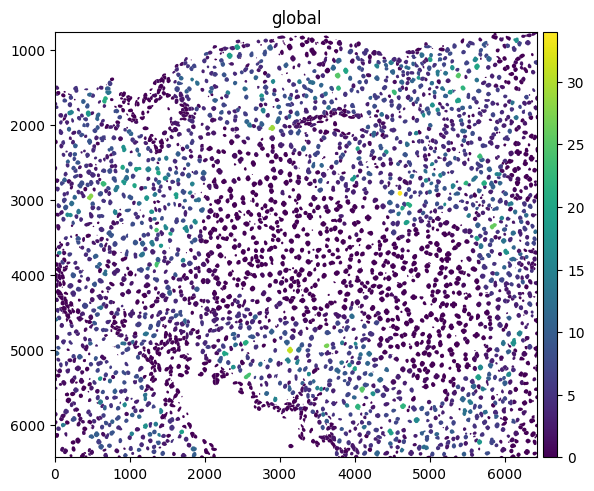

In [28]:
sdata.pl.render_shapes("nucleus_boundaries", color="Hal").pl.show()

Now is an example of plotting categorical information (cell types).

/home/chrism/git/spatialdata-notebooks/.venv/lib/python3.11/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `nucleus_boundaries` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/home/chrism/git/spatialdata-notebooks/.venv/lib/python3.11/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/home/chrism/git/spatialdata-notebooks/.venv/lib/python3.11/site-packages/spatialdata_plot/pl/utils.py:775: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


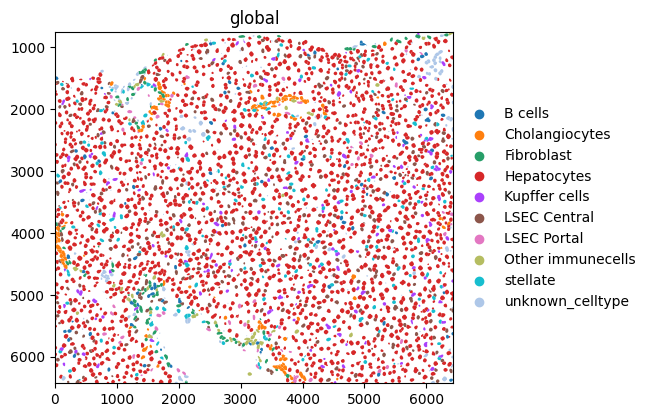

In [42]:
sdata.pl.render_shapes("nucleus_boundaries", color="annotation").pl.show()

Let's visualize all the layers together. We can easily chain the operations to render multiple `Elements` overlayed on top of each other in the same plot.

/home/chrism/git/spatialdata-notebooks/.venv/lib/python3.11/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `nucleus_boundaries` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/home/chrism/git/spatialdata-notebooks/.venv/lib/python3.11/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/home/chrism/git/spatialdata-notebooks/.venv/lib/python3.11/site-packages/spatialdata_plot/pl/utils.py:775: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)
/home/chrism/git/spatialdata-notebooks/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The

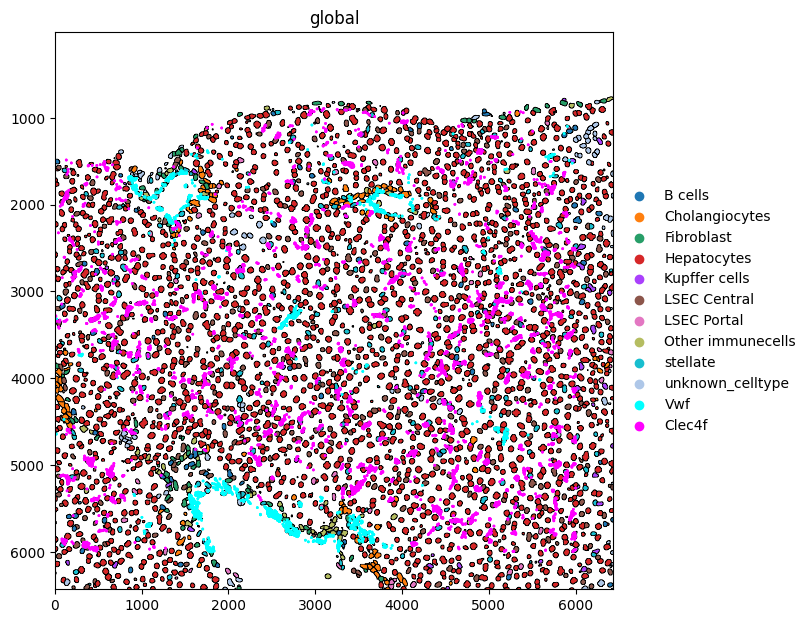

In [43]:
(
    sdata.pl.render_shapes(
        "nucleus_boundaries",
        color="annotation",
        outline_alpha=1.0,
        outline_width=0.5,
    )
    .pl.render_points(
        "transcripts",
        color="gene",
        groups="Vwf",
        palette="cyan",
    )
    .pl.render_points(
        "transcripts",
        color="gene",
        groups="Clec4f",
        palette="magenta",
    )
    .pl.show(figsize=(8, 8))
)

## Spatial Querying and Subsetting

Given a single-modal or multi-modal dataset, spatial queries allow to retrieve all the spatial elements and instances that are within a given rectangular window or polygonal shape. 

For the purpose of this tutorial, our dataset is conveniently aligned to a single coordinate system `global`.

> **See Also**
> 
> For advanced usage of coordinate systems and transformations see the [Transformations](transformations.ipynb) notebooks, for a more in-depth look at query operations, see the [Spatial Queries](spatial_query.ipynb) notebook.

Bounding box query subsets a given `SpatialData` object within a rectangular window. We can get the bounds of the dataset to help define min/max coordinates.

In [44]:
sd.get_extent(sdata)

{'y': (np.float64(0.0), np.float64(6432.0)),
 'x': (np.float64(0.0), np.float64(6432.0))}

To perform a bounding box query, we provide the axes, min/max coordinates, and the target coordinate system for the bounding box coordinates.


In [45]:
crop_sdata1 = sd.bounding_box_query(
    sdata, axes=("y", "x"), min_coordinate=[1000, 1000], max_coordinate=[2000, 2000], target_coordinate_system="global"
)
crop_sdata1

/home/chrism/.local/share/uv/python/cpython-3.11.12-linux-x86_64-gnu/lib/python3.11/functools.py:909: UserWarning: The object has `points` element. Depending on the number of points, querying MAY suffer from performance issues. Please consider filtering the object before calling this function by calling the `subset()` method of `SpatialData`.
  return dispatch(args[0].__class__)(*args, **kw)


SpatialData object
├── Images
│     └── 'raw_image': DataTree[cyx] (1, 1000, 1000), (1, 250, 250)
├── Labels
│     └── 'segmentation_mask': DataArray[yx] (1000, 1000)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 3) (2D points)
├── Shapes
│     └── 'nucleus_boundaries': GeoDataFrame shape: (96, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (96, 99)
with coordinate systems:
    ▸ 'global', with elements:
        raw_image (Images), segmentation_mask (Labels), transcripts (Points), nucleus_boundaries (Shapes)

/home/chrism/git/spatialdata-notebooks/.venv/lib/python3.11/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `nucleus_boundaries` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/home/chrism/git/spatialdata-notebooks/.venv/lib/python3.11/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/home/chrism/git/spatialdata-notebooks/.venv/lib/python3.11/site-packages/spatialdata_plot/pl/utils.py:775: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


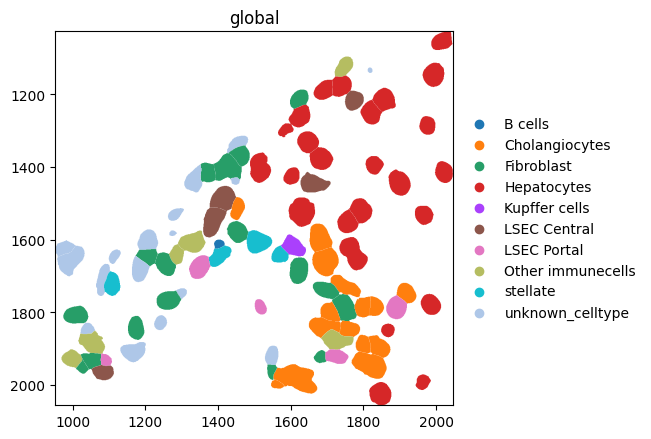

In [46]:
crop_sdata1.pl.render_shapes("nucleus_boundaries", color="annotation").pl.show()

Similarly, we can perform a polygon query by using a `shapely.Polygon` object and passing the target coordinate system.

In [47]:
from shapely import Polygon

polygon = Polygon([(1000, 1000), (1500, 1000), (2000, 1500), (1500, 2000)])
crop_sdata2 = sd.polygon_query(sdata, polygon, target_coordinate_system="global")
crop_sdata2

SpatialData object
├── Images
│     └── 'raw_image': DataTree[cyx] (1, 1000, 1000), (1, 250, 250)
├── Labels
│     └── 'segmentation_mask': DataArray[yx] (1000, 1000)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 3) (2D points)
├── Shapes
│     └── 'nucleus_boundaries': GeoDataFrame shape: (45, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (45, 99)
with coordinate systems:
    ▸ 'global', with elements:
        raw_image (Images), segmentation_mask (Labels), transcripts (Points), nucleus_boundaries (Shapes)

/home/chrism/git/spatialdata-notebooks/.venv/lib/python3.11/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `nucleus_boundaries` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/home/chrism/git/spatialdata-notebooks/.venv/lib/python3.11/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/home/chrism/git/spatialdata-notebooks/.venv/lib/python3.11/site-packages/spatialdata_plot/pl/utils.py:775: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


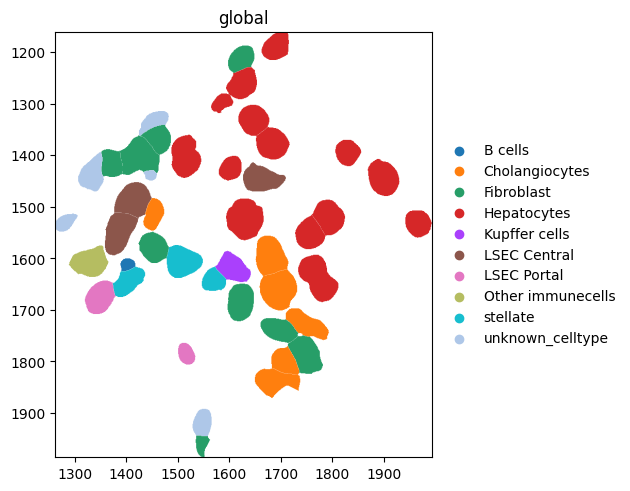

In [48]:
crop_sdata2.pl.render_shapes("nucleus_boundaries", color="annotation").pl.show()

### Saving `SpatialData` Objects

Currently, the cropped `SpatialData` object only exists in memory. Let's save it by writing it to disk in a new `.zarr` store.

> **Note**
>
> It is not recommended to modify this in place. For more information on incremental reading and writing of `SpatialData` objects, [see more here](https://github.com/scverse/spatialdata/discussions/520).

In [49]:
from pathlib import Path
from tempfile import TemporaryDirectory

tmpdir = TemporaryDirectory()
crop_sdata2.write(Path(tmpdir.name) / "crop.zarr")

INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside /tmp/tmp1pbopoc6/crop.zarr). Please see the documentation of `is_self_contained()` to   
         understand the implications of working with SpatialData objects that are not self-contained.              
INFO     The Zarr backing store has been changed from None the new file path: /tmp/tmp1pbopoc6/crop.zarr           


### Saving new elements

Let's say we want to add a new element to our cropped `SpatialData` object. For example, we can subset the nucleus boundaries to only include a single cell type, cholangiocytes and save it as a new element. First retrieve the cell type annotations from the table.

In [50]:
cell_types = sd.get_values("annotation", crop_sdata2["table"])["annotation"]

Slice the nucleus boundaries to only include cholangiocytes and save it as a new element.

In [52]:
crop_sdata2["cholangiocytes"] = crop_sdata2["nucleus_boundaries"][cell_types == "Cholangiocytes"]

/home/chrism/git/spatialdata-notebooks/.venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1750: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


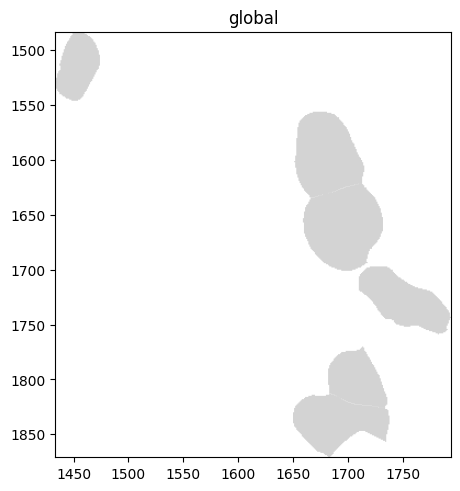

In [54]:
crop_sdata2.pl.render_shapes("cholangiocytes").pl.show()

Note that sdata['cholangiocytes'] only exists in-memory until we explicity write it to disk with `crop_sdata2.write_element()`. Let's do that now.

In [ ]:
crop_sdata2.write_element("cholangiocytes")

In [ ]:
tmpdir.cleanup()


## Next Steps

Congratulations! Now you know the basics of `SpatialData` and how to use the core APIs. Check out the [other tutorials](../../notebooks.md) for more advanced usage, integrated packages, and technology-specific examples. In particular, the section "External tutorials" will link to analysis notebooks, available in third-party libraries that use `SpatialData` objects as a data model.